# Tabula Rasa

---

---

### Overview

This notebook trains a mixed monotonic model, with sub-models to generate arbitrary quantile predictions and estimate epistemic uncertainty, using `TabulaRasaRegressor()`.

It's designed to work with Pandas DataFrame's and takes advantage of class types and feature names to cut down on code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabularasa.TabulaRasa import TabulaRasaRegressor

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [2]:
df = pd.read_pickle('./data/simple_train.pkl')

Let's convert `x3` to a `category` data type so that we can generate embeddings for it (`TabulaRasaRegressor()` automatically handles this for all columns with `object` or `category` data types).

In [3]:
df['x3'] = df['x3'].astype('category')

---

### Initialize  and train

When initializing the model, we typically pass 3 arguments:
- `df`: A `pandas.DataFrame` containing the training data, or a sample of it.  No training happens on initialization, just categorizing features, setting up categorical feature mappings, and scalers for numeric features.  Therefore, if it is a sample of the full dataset, it should well represent your full dataset (in terms of having unique values for each categorical feature, and distributions for continuous features).
- `targets`: A `list` of column names to use as regressand(s) which are in `df`.  All other 'number', 'category', or 'object' columns in `df` are assumed to be features and will be included in the models. 
- `monotonic_constraints`: A `dict` where keys are features (column names on `df`) to take on monotonic relationships with the `targets` and values are 1 or -1 to signify the direction of that relationship: increasing or decreasing (respectively).
- `TabulaRasaRegressor()` also accepts named arguments, which are passed to the methods that define the three models behind the scenes.  Review the source code for `TabulaRasaRegressor()._define_model()` for more detail.  Here, we only specify `lr=0.005`.

In [4]:
model = TabulaRasaRegressor(df,
                            targets=['y'],
                            monotonic_constraints={'x1': 1, 'x2': 1},
                            lr=0.003)

Now, when we run `.fit()`, we'll train 3 models:
- The first generates standard predictions.
- The second can be used to estimate epistemic uncertainty.
- The third can generate predictions for arbitrary quantiles.

Note, we break pure adherence to the scikit API and simply pass the dataset which includes both the feature and target columns we'd like to train on into `.fit()`.

In [5]:
model.fit(df)

*** Training expectation model ***
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9563        0.9318  1.5977
      2        0.9351        0.9356  1.6563
      3        0.9247        0.9237  1.6313
      4        0.9194        0.9219  1.4718
      5        0.9164        0.9214  1.4407
      6        0.9166        0.9212  1.4451
      7        0.9096        0.9104  1.4357
      8        0.9063        0.9085  1.4348
      9        0.9065        0.9199  1.4248
     10        0.9024        0.9125  1.4446
     11        0.8999        0.9032  1.4215
     12        0.8850        0.9000  1.4480
     13        0.8868        0.8902  1.4286
     14        0.8918        0.8753  1.4296
     15        0.8760        0.9272  1.4518
     16        0.8743        0.8887  1.4412
     17        0.8526        0.8416  1.4412
     18        0.7997        0.7521  1.4454
     19        0.6779        0.5861  1.4513
     20        0.5041        0.3806  1.44

     50        0.0108        0.0108  0.0398
     51        0.0108        0.0108  0.0397
     52        0.0107        0.0107  0.0416
     53        0.0107        0.0107  0.0436
     54        0.0107        0.0107  0.0418
     55        0.0106        0.0106  0.0424
     56        0.0106        0.0106  0.0437
     57        0.0106        0.0106  0.0397
     58        0.0106        0.0105  0.0426
     59        0.0105        0.0105  0.0398
     60        0.0105        0.0105  0.0398
     61        0.0105        0.0105  0.0445
     62        0.0105        0.0104  0.0429
     63        0.0104        0.0104  0.0393
     64        0.0104        0.0104  0.0445
     65        0.0104        0.0104  0.0388
     66        0.0104        0.0104  0.0438
     67        0.0103        0.0103  0.0440
     68        0.0103        0.0103  0.0393
     69        0.0103        0.0103  0.0413
     70        0.0103        0.0103  0.0446
     71        0.0103        0.0102  0.0394
     72        0.0102        0.0

    185        0.0091        0.0090  0.0517
    186        0.0090        0.0090  0.0422
    187        0.0090        0.0090  0.0437
    188        0.0090        0.0090  0.0447
    189        0.0090        0.0090  0.0442
    190        0.0090        0.0090  0.0410
    191        0.0090        0.0090  0.0439
    192        0.0090        0.0090  0.0503
    193        0.0090        0.0090  0.0439
    194        0.0090        0.0090  0.0451
    195        0.0090        0.0090  0.0410
    196        0.0090        0.0090  0.0439
    197        0.0090        0.0090  0.0435
    198        0.0090        0.0090  0.0402
    199        0.0090        0.0090  0.0429
    200        0.0090        0.0090  0.0439
    201        0.0090        0.0090  0.0440
    202        0.0090        0.0090  0.0465
    203        0.0090        0.0090  0.0430
    204        0.0090        0.0090  0.0416
    205        0.0090        0.0090  0.0405
    206        0.0090        0.0090  0.0444
    207        0.0090        0.0

     97        0.1147        0.1414  1.8496
     98        0.1189        0.1341  1.8430
     99        0.1201        0.1426  1.8773
    100        0.1182        0.1313  1.8718


We'll create a partial dependence plot to visualize how the monotonic network constrained our relationship between `x1` and `y`.

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

Note, the `.predict()` method for `TabulaRasaRegressor()` accepts a data frame as well.  This data frame must include all training features, but does not need to include target column(s).

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict(dfc)
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

We can see below that, unlike with the simple MLP network, we have a monotonically increasing relationship between `x1` and `y`.

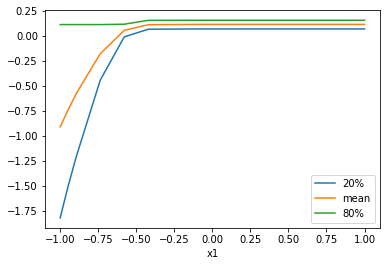

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

---

### Epistemic uncertainty

`TabulaRasaRegressor()` automatically trains and Orthornormal certificates model, and includes a method `.estimate_uncertainty()`, which accepts a data frame that must include all training features, but does not need to contain target column(s).

In [9]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.estimate_uncertainty(dfc)
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

And we can see from the plot below that uncertainties rise above 1 when projecting outside of the bounds we trained.  There is a bump in the middle, but it does not exceed 1 or align perfectly with the gap in our training data from 0 to 0.5.  Instead we see higher uncertainty when the function shows  high degree of curvature.

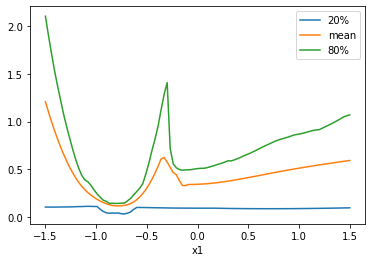

In [10]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

---

### Aleatoric uncertainty

`TabulaRasaRegressor()` also automatically trains a simultaneous quantile regression model.  Let's see how to use that.

Since each distinct value of `x3` contains all values of `x1`, let's examine prediction intervals by `x1` for a single value of `x3`.

In [11]:
df_slice = df[df['x3'] == 1].copy()

The `.predict_quantile()` takes in an extra argument `q` to specify which quantile should be predicted (defaults to 0.5, the 50th percentile).

In [12]:
p05 = model.predict_quantile(df_slice, q=0.05)
p = model.predict(df_slice)
p50 = model.predict_quantile(df_slice, q=0.5)
p95 = model.predict_quantile(df_slice, q=0.95)

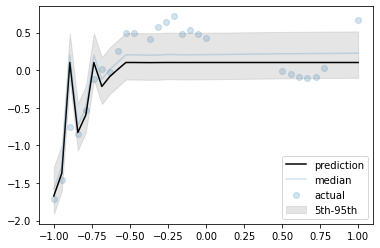

In [13]:
plt.scatter(df_slice['x1'], df_slice['y'], alpha=0.2, label='actual')
plt.plot(df_slice['x1'], p.flatten(), color='black', label='prediction')
plt.plot(df_slice['x1'], p50.flatten(), alpha=0.2, label='median')
plt.fill_between(df_slice['x1'], p05.flatten(), p95.flatten(), color='gray', alpha=0.2, label='5th-95th')
plt.legend()
plt.show()

We can see the 5th and 95th percentile prediction bounds capture the variation of most points around the median and base prediction model estimate, and can be used to approximate the aleatoric uncertainty in our model.